In [17]:
import pandas as pd
import numpy as np
import math
import datetime

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
# Set seeds for reproducibility
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()


In [ ]:
df = pd.read_csv('Sunspots.csv')
df = df[['Monthly Mean Total Sunspot Number']]
print("First few rows of the dataset:")
print(df.head())

# Convert DataFrame to NumPy array
df_values = df.to_numpy()

First few rows of the dataset:
   Monthly Mean Total Sunspot Number
0                               96.7
1                              104.3
2                              116.7
3                               92.8
4                              141.7


In [19]:
def truncate(x, feature_cols=range(1), target_cols=range(1), train_len=16, test_len=1):
    in_, out_ = [], []
    for i in range(len(x) - train_len - test_len + 1):
        in_.append(x[i:(i + train_len), feature_cols].tolist())
        out_.append(x[(i + train_len):(i + train_len + test_len), target_cols].tolist())
    return np.array(in_), np.array(out_)

In [20]:
# Truncate the data
train_len = 16
test_len = 1
feature_cols = range(1)  # Using the first column as feature
target_cols = range(1)   # Using the first column as target

X_in, X_out = truncate(df_values, feature_cols=feature_cols, target_cols=target_cols, train_len=train_len, test_len=test_len)
print(f"Input shape: {X_in.shape}, Output shape: {X_out.shape}")


Input shape: (3249, 16, 1), Output shape: (3249, 1, 1)


In [21]:
# Reshape output to (samples, 1)
X_out = X_out.reshape(-1, 1)
print(f"Reshaped Output shape: {X_out.shape}")

Reshaped Output shape: (3249, 1)


In [22]:
# Split into training and testing sets (70% train, 30% test)
train_size = math.floor(X_in.shape[0] * 0.70)
train_x, train_y = X_in[:train_size], X_out[:train_size]
test_x, test_y = X_in[train_size:], X_out[train_size:]
print(f"Train X shape: {train_x.shape}, Train Y shape: {train_y.shape}")
print(f"Test X shape: {test_x.shape}, Test Y shape: {test_y.shape}")


Train X shape: (2274, 16, 1), Train Y shape: (2274, 1)
Test X shape: (975, 16, 1), Test Y shape: (975, 1)


In [23]:

# Define custom quantile loss
def quantile_loss(quantile):
    def loss(y_true, y_pred):
        errors = y_true - y_pred
        return tf.reduce_mean(tf.maximum(quantile * errors, (quantile - 1) * errors), axis=-1)
    return loss

In [24]:
def build_model(input_shape):
    input_layer = Input(shape=input_shape)
    initializer = tf.keras.initializers.GlorotNormal()

    lstm1 = LSTM(256, activation='relu', kernel_initializer=initializer, return_sequences=True)(input_layer)
    dropout1 = Dropout(0.3)(lstm1)
    lstm2 = LSTM(128, activation='relu', kernel_initializer=initializer, return_sequences=False)(dropout1)
    dropout2 = Dropout(0.2)(lstm2)
    output = Dense(1)(dropout2)  # Single output for quantile

    model = Model(inputs=input_layer, outputs=output)
    return model

In [25]:
q_low = 0.025
q_high = 0.975

# Build two separate models for lower and upper quantiles
model_low = build_model((train_len, 1))
model_high = build_model((train_len, 1))

c:\Users\aades\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [26]:
# Compile the models with respective quantile losses
model_low.compile(loss=quantile_loss(q_low), optimizer=Adam(learning_rate=0.001))
model_high.compile(loss=quantile_loss(q_high), optimizer=Adam(learning_rate=0.001))

In [27]:
epochs = 300
batch_size = 128
patience = 10

early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)

In [ ]:
# Train the lower quantile model
print("\nTraining Lower Quantile Model")
start_time_low = datetime.datetime.now()
history_low = model_low.fit(
    train_x, train_y,
    validation_split=0.1,
    epochs=epochs,
    verbose=1,
    batch_size=batch_size,
    callbacks=[early_stopping]
)
end_time_low = datetime.datetime.now()
total_time_low = end_time_low - start_time_low
print(f"Lower Quantile Model Training time: {round(total_time_low.total_seconds(), 2)} seconds")


Training Lower Quantile Model (2.5%)
Epoch 1/300
16/16 [==============================] - 12s 268ms/step - loss: 1.9335 - val_loss: 1.6186
Epoch 2/300
16/16 [==============================] - 3s 201ms/step - loss: 1.7336 - val_loss: 1.8197
Epoch 3/300
16/16 [==============================] - 3s 198ms/step - loss: 1.6440 - val_loss: 1.5897
Epoch 4/300
16/16 [==============================] - 3s 197ms/step - loss: 1.5971 - val_loss: 1.5155
Epoch 5/300
16/16 [==============================] - 3s 201ms/step - loss: 1.5896 - val_loss: 1.4088
Epoch 6/300
16/16 [==============================] - 3s 190ms/step - loss: 1.4402 - val_loss: 1.4683
Epoch 7/300
16/16 [==============================] - 3s 181ms/step - loss: 1.3882 - val_loss: 1.3129
Epoch 8/300
16/16 [==============================] - 3s 185ms/step - loss: 1.3310 - val_loss: 1.3041
Epoch 9/300
16/16 [==============================] - 3s 193ms/step - loss: 1.3036 - val_loss: 1.2684
Epoch 10/300
16/16 [==============================] 

In [ ]:
# Train the upper quantile model
print("\nTraining Upper Quantile Model")
start_time_high = datetime.datetime.now()
history_high = model_high.fit(
    train_x, train_y,
    validation_split=0.1,
    epochs=epochs,
    verbose=1,
    batch_size=batch_size,
    callbacks=[early_stopping]
)
end_time_high = datetime.datetime.now()
total_time_high = end_time_high - start_time_high
print(f"Upper Quantile Model Training time: {round(total_time_high.total_seconds(), 2)} seconds")


Training Upper Quantile Model (97.5%)
Epoch 1/300
16/16 [==============================] - 12s 242ms/step - loss: 9.3416 - val_loss: 3.4185
Epoch 2/300
16/16 [==============================] - 3s 180ms/step - loss: 4.3434 - val_loss: 4.2396
Epoch 3/300
16/16 [==============================] - 3s 182ms/step - loss: 3.9775 - val_loss: 2.7059
Epoch 4/300
16/16 [==============================] - 3s 177ms/step - loss: 3.1928 - val_loss: 2.2774
Epoch 5/300
16/16 [==============================] - 3s 179ms/step - loss: 3.2288 - val_loss: 2.0554
Epoch 6/300
16/16 [==============================] - 3s 179ms/step - loss: 2.9885 - val_loss: 2.7103
Epoch 7/300
16/16 [==============================] - 3s 177ms/step - loss: 2.9553 - val_loss: 2.0859
Epoch 8/300
16/16 [==============================] - 3s 174ms/step - loss: 3.6390 - val_loss: 2.9987
Epoch 9/300
16/16 [==============================] - 3s 179ms/step - loss: 3.9079 - val_loss: 7.8852
Epoch 10/300
16/16 [==============================]

In [36]:
# Make predictions with both models
print("\nMaking Predictions")
y_l_pred = model_low.predict(test_x, verbose=0).flatten()
y_u_pred = model_high.predict(test_x, verbose=0).flatten()
test_y_flat = test_y.flatten()

print(f"Lower Predictions shape: {y_l_pred.shape}")
print(f"Upper Predictions shape: {y_u_pred.shape}")
print(f"Test Y shape: {test_y_flat.shape}")


Making Predictions
Lower Predictions shape: (975,)
Upper Predictions shape: (975,)
Test Y shape: (975,)


In [37]:
# Calculate PICP and MPIW
K_u = y_u_pred >= test_y_flat
K_l = y_l_pred <= test_y_flat
PICP = np.mean(K_u & K_l)
MPIW = np.mean(y_u_pred - y_l_pred)

# Calculate total training time
total_training_time = total_time_low + total_time_high
print(f"\nTotal Training Time (Lower + Upper Quantile Models): {round(total_training_time.total_seconds(), 2)} seconds")

print(f"\nPICP (Prediction Interval Coverage Probability): {PICP}")
print(f"MPIW (Mean Prediction Interval Width): {round(MPIW, 3)}")


Total Training Time (Lower + Upper Quantile Models): 135.05 seconds

PICP (Prediction Interval Coverage Probability): 0.9558974358974359
MPIW (Mean Prediction Interval Width): 144.21600341796875


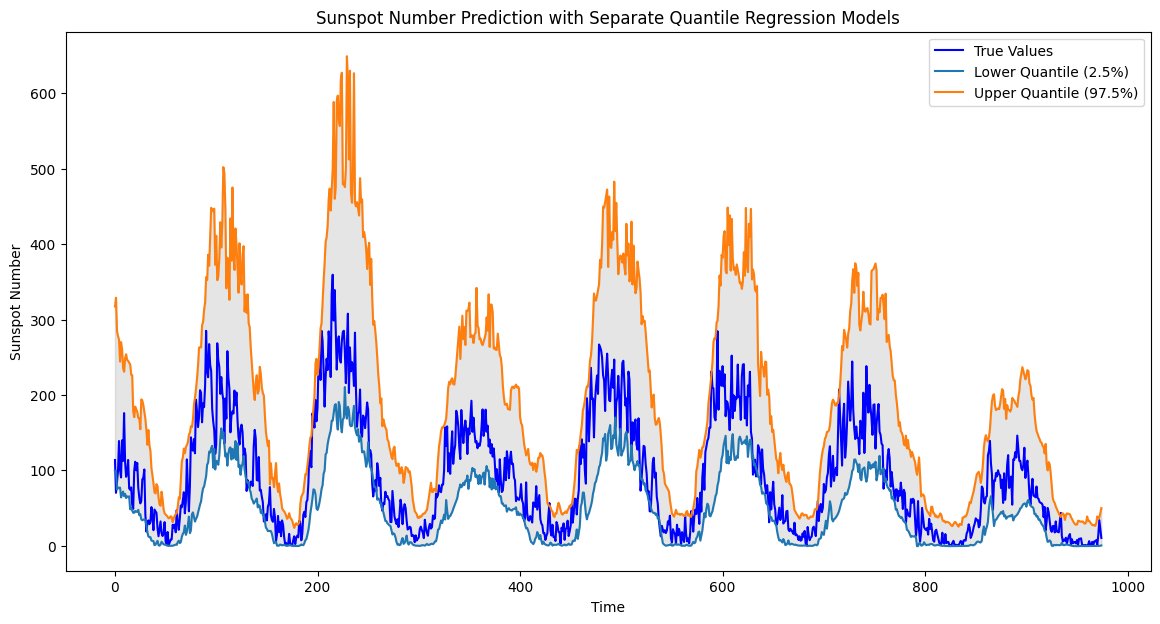

In [ ]:
# Optional: Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(test_y_flat, label='True Values', color='blue')
plt.plot(y_l_pred, label='Lower Quantile')
plt.plot(y_u_pred, label='Upper Quantile')
plt.fill_between(range(len(test_y_flat)), y_l_pred, y_u_pred, color='gray', alpha=0.2)
plt.legend()
plt.title('Sunspot Number Prediction with Separate Quantile Regression Models')
plt.xlabel('Time')
plt.ylabel('Sunspot Number')
plt.show()